In [8]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy


In [ ]:
# First fly test 
bag_name = "./bags/first_fly_test.bag"
#b = bagreader(bag_name)

bag_paths = []
for bag_name in os.listdir("./bags"):
    bag_paths.append("./bags/{}".format(bag_name))

print(bag_paths)
b = bagreader(bag_paths[1])

['./bags/second_fly_test.bag', './bags/first_fly_test.bag', './bags/fourth_try_test.bag', './bags/third_fly_test.bag']


In [7]:
csv_files = []
for topic in b.topics:
    data = b.message_by_topic(topic)
    csv_files.append(data)

FileNotFoundError: [Errno 2] No such file or directory: './bags/first_fly_test/red-mavros-adsb-vehicle.csv'

In [ ]:
topic_name = "detected_objects"
for i, name in enumerate(csv_files): 
    if topic_name in name: 
        print("{}: {}".format(i, name))

In [ ]:
det_objs = pd.read_csv(csv_files[0])
uav_pose = pd.read_csv(csv_files[2]); uav_pose = scale_time(uav_pose)
net_pose = pd.read_csv(csv_files[7]); net_pose = scale_time(net_pose)


In [ ]:
def find_closest_values(s, x):
    idx = (np.abs(s - x)).argmin()
    return idx
    
def crop_df_time(df, start_time, end_time):
    
    start_index = find_closest_values(df['Time'], start_time)
    end_index = find_closest_values(df['Time'], end_time)
    return df[start_index:end_index]

def upsample_dataframes(df1, df2):
    # Check which dataframe has fewer measurements
    if len(df1) < len(df2):
        shorter_df, longer_df = df1, df2
    else:
        shorter_df, longer_df = df2, df1

    # Calculate the ratio for upsampling
    ratio = len(longer_df) // len(shorter_df)

    # Upsample the shorter dataframe to match the length of the longer dataframe
    upsampled_shorter_df = pd.concat([shorter_df] * ratio, ignore_index=True)

    # Trim the longer dataframe to match the length of the shorter dataframe
    trimmed_longer_df = longer_df.iloc[:len(upsampled_shorter_df)]

    return trimmed_longer_df, upsampled_shorter_df

In [ ]:
def plot_position(pandas_odometry): 
    t = pandas_odometry['Time']
    x = pandas_odometry['pose.pose.position.x']
    y = pandas_odometry['pose.pose.position.y']
    z = pandas_odometry['pose.pose.position.z']
    
    plt.figure(figsize=(14, 5))

    # Plot positions over time
    plt.plot(t, x, label='X Position', linestyle='-', marker='o')
    plt.plot(t, y, label='Y Position', linestyle='-', marker='s')
    plt.plot(t, z, label='Z Position', linestyle='-', marker='^')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position[m]')
    plt.title('Position')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def get_relative_position(odom1, odom2): 
    
    t1 = odom1['Time']; t2 = odom2['Time']
    len_t1 = len(t1); len_t2 = len(t2)
    
    if len(t1) > len(t2): 
        len_t1 = len(t2)
    else: 
        len_t2 = len(t1)
        
    print(len_t1)
    print(len_t2)
        
    x1 = odom1['pose.pose.position.x'][:len_t1]
    y1 = odom1['pose.pose.position.y'][:len_t1]
    z1 = odom1['pose.pose.position.z'][:len_t1]
    
    x2 = odom2['pose.pose.position.x'][:len_t2]
    y2 = odom2['pose.pose.position.y'][:len_t2]
    z2 = odom2['pose.pose.position.z'][:len_t2]
    t1 = t1[:len_t1]
    t2 = t2[:len_t2]
    
    t = t1
    x = x1-x2
    y = y1-y2
    z = z1-z2 
    
    return t,x,y,z
    
def plot_relative_position(t, x, y, z): 
    
    plt.figure(figsize=(10, 6))

    # Plot positions over time
    plt.plot(t, x, label='X Position', linestyle='-')
    plt.plot(t, y, label='Y Position', linestyle='-')#, marker='s')
    plt.plot(t, z, label='Z Position', linestyle='-')#, marker='^')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position')
    plt.title('Positions Over Time')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
    

In [ ]:

def plot_trajectory(x_coords, y_coords, z_coords):
    """
    Plots a trajectory in 3D space.

    Parameters:
    - x_coords (list): List of x-coordinates.
    - y_coords (list): List of y-coordinates.
    - z_coords (list): List of z-coordinates.

    Returns:
    - None
    """
    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory as a 3D line
    ax.plot(x_coords, y_coords, z_coords, label='Trajectory', linewidth=2)

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
plot_position(uav_pose)
plot_position(net_pose)

In [ ]:
def plot_positions(object1_positions, object2_positions, time_values):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    if len(object1_positions) != len(object2_positions) or len(object1_positions) != len(time_values):
        raise ValueError("Input arrays must have the same length.")

    # Create a 2x1 subplot grid
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    # Plot object 1 positions
    ax1.plot(time_values, object1_positions, label='Object 1', color='blue', marker='o')
    ax1.set_ylabel('Position of Object 1')
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(time_values, object2_positions, label='Object 2', color='green', marker='s')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position of Object 2')
    ax2.legend()

    # Set a title for the entire subplot
    plt.suptitle('Positions of Two Objects Over Time')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Replace these with your own data
time_values = np.linspace(0, 10, 100)
object1_positions = np.sin(time_values)
object2_positions = np.cos(time_values)

plot_positions(object1_positions, object2_positions, time_values)



In [ ]:
#uav_pose_cropped = crop_df_time(uav_pose, 200, 300)
#net_pose_cropped = crop_df_time(net_pose, 200, 300)
t, x, y, z = get_relative_position(uav_pose, net_pose)
plot_relative_position(t, x, y, z)

# TODO: 
- [x] Plot UAV and the NET position 
- [x] Plot relative position
- [x] Plot net orientation
- [ ] Plot UAV and the NET position for the multiple times 
- [ ] Crop method based on the time
- [ ] Plot relative position between UAV - NET (done) and Object (not done)  

## Findings: 
- [x] When optitrack loses markers, we lose measurements (more optitrack markers)
- [ ] Optitrack markers on a can (to record even relative position between net and the object) 

In [155]:
uav_pose_new, net_pose_new = upsample_dataframes(uav_pose, net_pose)

50238
50238


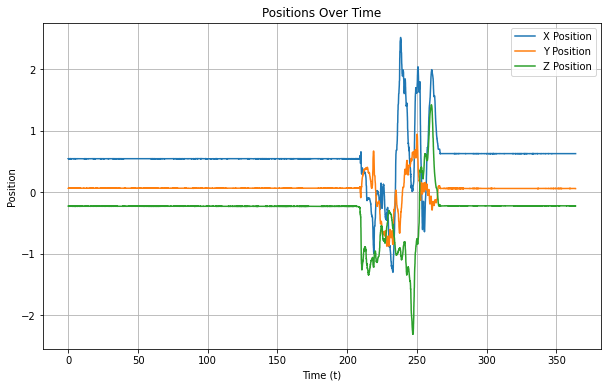

In [156]:
t, x, y, z = get_relative_position(uav_pose_new, net_pose_new)
plot_relative_position(t, x, y, z)